# Keras Unet Starter

모델을 학습시키고 테스트 이미지로 테스트해본다!

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import socket
hostname = socket.gethostname()
print(hostname)

devbox20


## 라이브러리

In [3]:
import os
import sys
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.measure import label, regionprops
from PIL import Image, ImageDraw
from ast import literal_eval
from tqdm.notebook import tqdm

import tensorflow as tf

from tensorflow.keras.models import Model, load_model

from tensorflow.keras import Input
from tensorflow.keras.layers import InputLayer, Dropout, Lambda
# from tensorflow.keras.layers.core import , Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
# import keras

In [4]:
print(tf.__version__) # 1.14.0
print(tf.keras.__version__) # 2.2.4

2.3.0
2.4.0


In [5]:
# 학습 할때 몇 번째 gpu를 사용할것인지 설정
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
# device_lib.list_local_devices()

In [6]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
SC_FACTOR = int(1024 / IMG_WIDTH) # scale factor
print(SC_FACTOR)

2


In [7]:
BASE_PATH = '/home/hyerin/data/global-wheat-detection/'
TRAIN_PATH = os.path.join(BASE_PATH, "train/")
TEST_PATH = os.path.join(BASE_PATH, "test/")
print(TRAIN_PATH)
print(TEST_PATH)

/home/hyerin/data/global-wheat-detection/train/
/home/hyerin/data/global-wheat-detection/test/


In [8]:
train_csv_path = os.path.join(BASE_PATH, "train.csv")
df = pd.read_csv(train_csv_path)
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [9]:
sample_sub = pd.read_csv(BASE_PATH + "sample_submission.csv")

In [10]:
# Get train and test IDs and paths
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)
print(len(train_ids))
print(len(test_ids))

3422
10


**Convert multiple bounding boxes to masks**<br>
bbox 부분을 mask.<br>
이미지를 줄일 것이니 scale factor 를 써서 bbox 크기도 함께 줄여야 한다.<br>
bbox 데이터가 있는 모든 이미지에 polygon을 그려준다.<br>


In [11]:
def make_polygon(coords):
    xm, ym, w, h = coords
    # scale values if image was downsized
    xm, ym, w, h = xm / SC_FACTOR, ym / SC_FACTOR, w / SC_FACTOR, h / SC_FACTOR   
    
    return [(xm, ym), (xm, ym + h), (xm + w, ym + h), (xm + w, ym)]

In [12]:
masks = dict() # dictionnary containing all masks

for img_id, gp in tqdm(df.groupby("image_id")):
    gp['polygons'] = gp['bbox'].apply(eval).apply(lambda x: make_polygon(x))

    img = Image.new('L', (IMG_WIDTH, IMG_HEIGHT), 0)
    for pol in gp['polygons'].values:
        ImageDraw.Draw(img).polygon(pol, outline=1, fill=1)

    mask = np.array(img, dtype=np.uint8)
    masks[img_id] = mask

  0%|          | 0/3373 [00:00<?, ?it/s]

In [13]:
# masks 확인
print("- polygon 이 그려진 이미지 shape :", masks[list(masks.keys())[1]].shape)
print("\n- polygon 이 그려진 이미지 개수 :", len(masks))

- polygon 이 그려진 이미지 shape : (512, 512)

- polygon 이 그려진 이미지 개수 : 3373


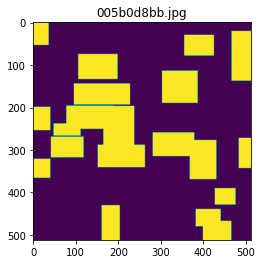

In [14]:
test_img_id = list(masks.keys())[1]
test_img = Image.fromarray(masks[test_img_id])
plt.title("{}.jpg".format(test_img_id))
plt.imshow(test_img)

**Train/Test Data**<br>
<br>
데이터셋을 만든다.<br>
X_train 은 원본이미지(1024,1024) 를 resize 한 다음 생성한다.<br>
Y_train 은 mask 된 이미지(위에서 생성한 masks)를 이용해 생성한다. <br>
- X_train : (512,512,3)
- Y_trina : (512,512,1)
<br><br>
- X_test : (512, 512,3)

In [15]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print("전체 Train 이미지에 대한")
print("X_train :", X_train.shape)
print("Y_train :", Y_train.shape)

전체 Train 이미지에 대한
X_train : (3422, 512, 512, 3)
Y_train : (3422, 512, 512, 1)


이미지를 resize 하고, masks에서 해당하는 mask 이미지를 가져온다

In [16]:
for n, id_ in tqdm(enumerate(train_ids[:]), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    id_clean = id_.split('.')[0]
    if id_clean in masks.keys():
        Y_train[n] = masks[id_clean][:, :, np.newaxis]
#         print(Y_train[n])

  0%|          | 0/3422 [00:00<?, ?it/s]

In [17]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
print("테스트 이미지에 대한")
print("X_test :", X_test.shape)

sizes_test = list()
print('\nGetting and resizing test images...')

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

테스트 이미지에 대한
X_test : (10, 512, 512, 3)

Getting and resizing test images...


  0%|          | 0/10 [00:00<?, ?it/s]

**원본 이미지 확인**

In [18]:
def show_images(images, num=2):    
    images_to_show = np.random.choice(images, num)
    for image_id in images_to_show:

        image_path = os.path.join(TRAIN_PATH, image_id + ".jpg")
        image = Image.open(image_path)

        # get all bboxes for given image in [xmin, ymin, width, height]
        bboxes = [literal_eval(box) for box in df[df['image_id'] == image_id]['bbox']]

        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:    
            draw.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], width=3)

        plt.figure(figsize = (5,5))
        plt.imshow(image)
        plt.show()

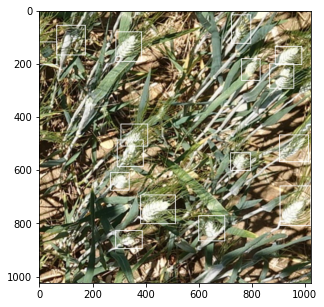

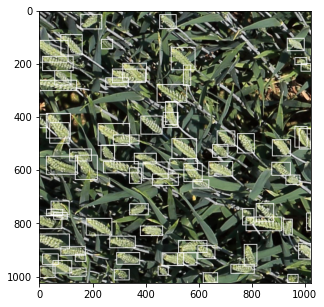

In [19]:
unique_images = df['image_id'].unique()
show_images(unique_images)

**Model and utils**

In [20]:
#Credits to : https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63044

def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred):

    tresholds = [0.5 + (i * 0.05)  for i in range(5)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [21]:
tresholds = [0.5 + (i * 0.05)  for i in range(5)]
print(tresholds)

[0.5, 0.55, 0.6, 0.65, 0.7]


**model 구성**

In [22]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)  # rescale inputs

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [23]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[competitionMetric2])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

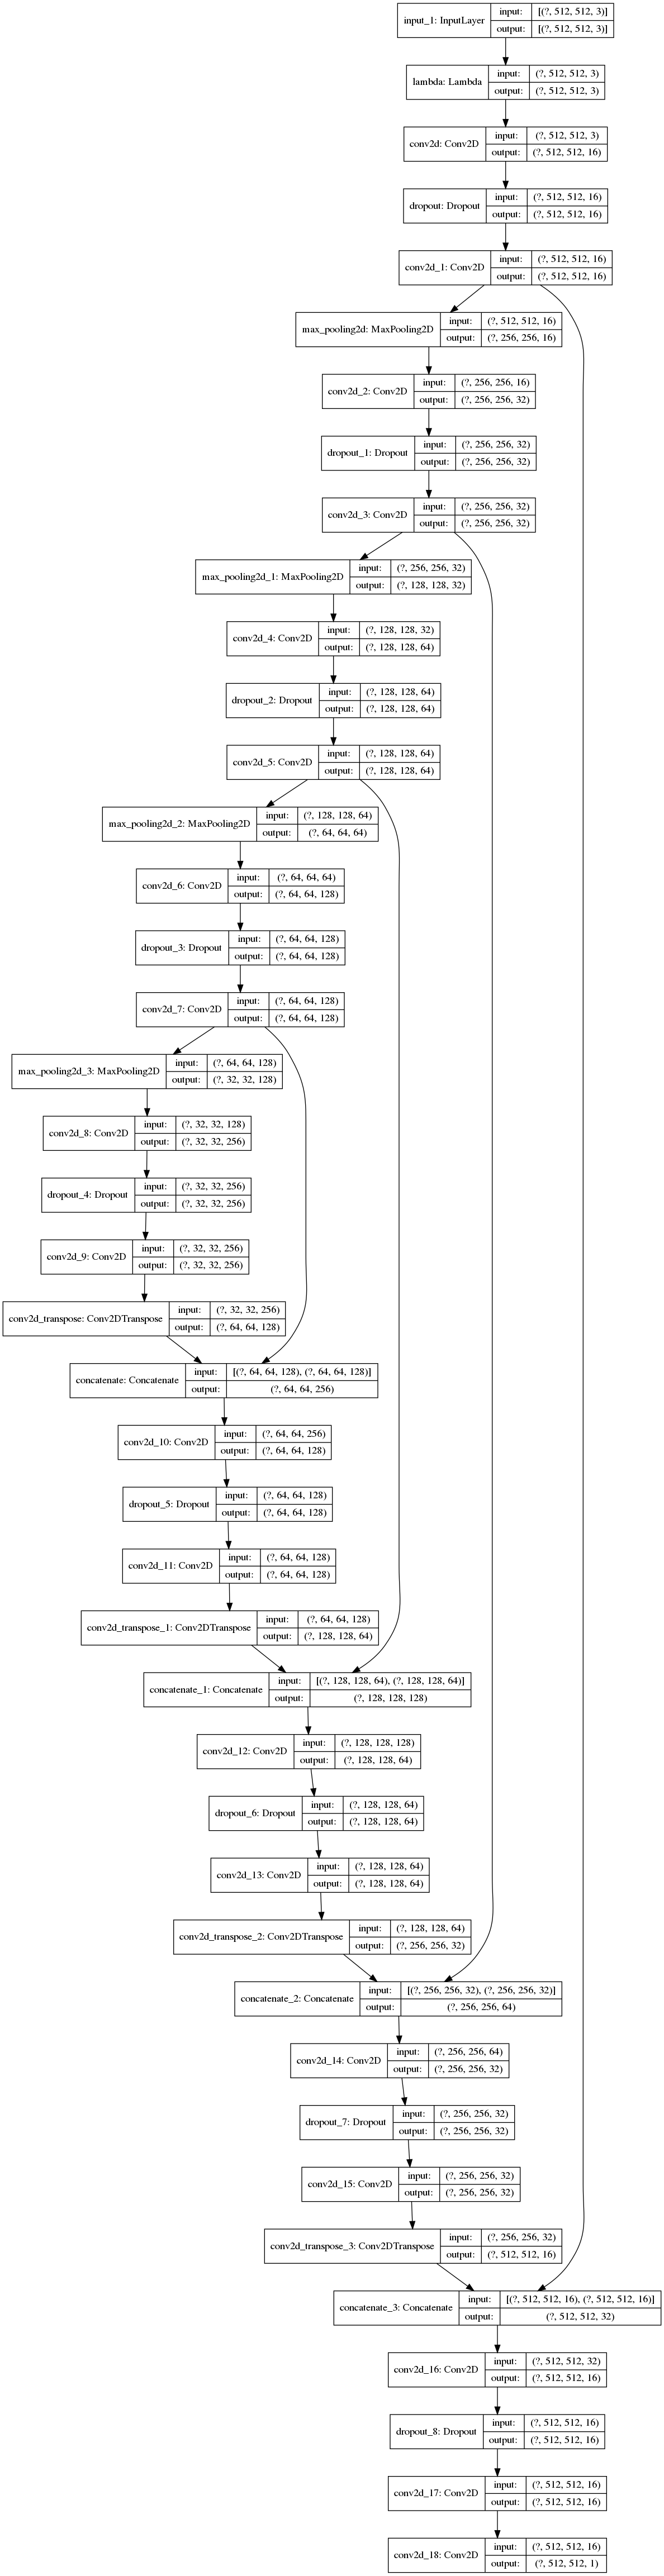

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image('model.png')

In [25]:
# Fit model
#earlystop = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate.hdf5', save_best_only=True, save_weights_only=True)

history = model.fit(X_train, 
         Y_train,
         validation_split=0.1,
         batch_size=4, 
         epochs=20, 
         callbacks=[es, chkpt],
        )

Epoch 1/20
770/770 [==============================] - 50s 64ms/step - loss: 0.4410 - competitionMetric2: 0.1271 - val_loss: 0.3417 - val_competitionMetric2: 0.2802
Epoch 2/20
770/770 [==============================] - 49s 64ms/step - loss: 0.3111 - competitionMetric2: 0.4776 - val_loss: 0.2759 - val_competitionMetric2: 0.5506
Epoch 3/20
770/770 [==============================] - 50s 64ms/step - loss: 0.2382 - competitionMetric2: 0.7185 - val_loss: 0.2144 - val_competitionMetric2: 0.8114
Epoch 4/20
770/770 [==============================] - 50s 65ms/step - loss: 0.2159 - competitionMetric2: 0.7901 - val_loss: 0.2073 - val_competitionMetric2: 0.8405
Epoch 5/20
770/770 [==============================] - 50s 65ms/step - loss: 0.2017 - competitionMetric2: 0.8342 - val_loss: 0.1909 - val_competitionMetric2: 0.8860
Epoch 6/20
770/770 [==============================] - 50s 65ms/step - loss: 0.1944 - competitionMetric2: 0.8543 - val_loss: 0.2018 - val_competitionMetric2: 0.8781
Epoch 7/20
770/7

In [26]:
# history.history

In [38]:
model.save("wheat_detection_unet_210630_1.h5")

**Prediction**<br><br>

output 은 mask 된 이미지

In [39]:
THRESH = 0.65

In [40]:
preds = model.predict(X_test)[:, :, :, 0]
masked_preds = preds > THRESH

In [41]:
preds[0]

array([[0.06676421, 0.06750643, 0.08243773, ..., 0.03262717, 0.03685373,
        0.05728976],
       [0.05087167, 0.06170204, 0.08570074, ..., 0.02401272, 0.03003773,
        0.03647655],
       [0.03316113, 0.05019498, 0.07546693, ..., 0.01915578, 0.0251105 ,
        0.03555695],
       ...,
       [0.04576047, 0.03675749, 0.03322745, ..., 0.00757033, 0.01191732,
        0.01377024],
       [0.05892726, 0.05106684, 0.05425011, ..., 0.00856245, 0.01209142,
        0.01559922],
       [0.08348064, 0.06204046, 0.06014361, ..., 0.00733064, 0.0103191 ,
        0.01758284]], dtype=float32)

In [42]:
masked_preds[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [43]:
preds.shape, masked_preds.shape

((10, 512, 512), (10, 512, 512))

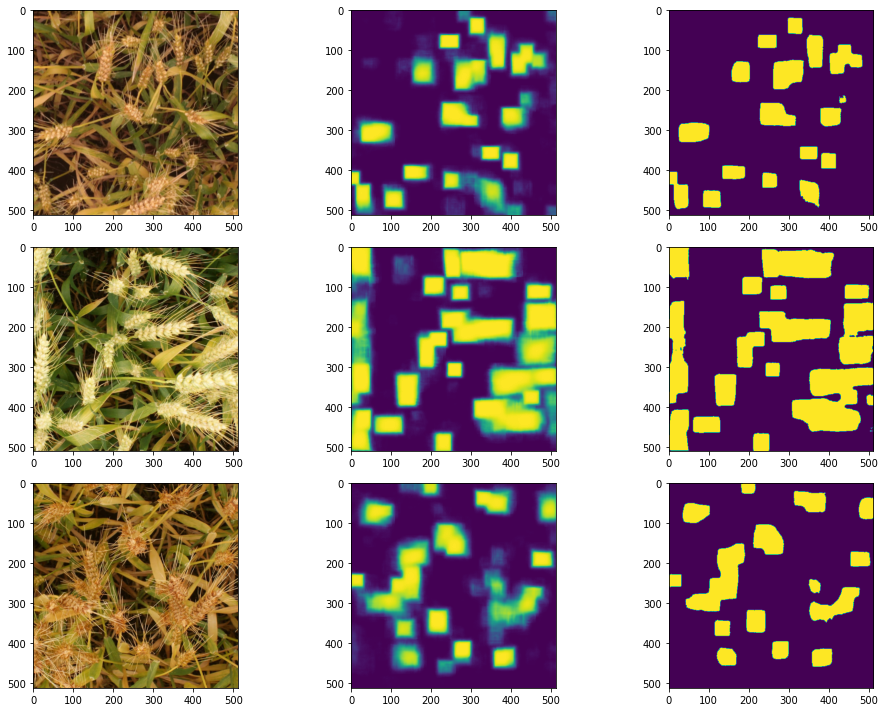

In [44]:
n_rows = 3
f, ax = plt.subplots(n_rows, 3, figsize=(14, 10))

for j, idx in enumerate([4,5,6]):
    for k, kind in enumerate(['original', 'pred', 'masked_pred']):
        if kind == 'original':
            img = X_test[idx]
        elif kind == 'pred':
            img = preds[idx]
        elif kind == 'masked_pred':
            masked_pred = preds[idx] > THRESH
            img = masked_pred
        ax[j, k].imshow(img)

plt.tight_layout()


**Convert masked predictions to several bouding boxes**<br>
<br>
mask 영역을 bbox 로 바꾸는 과정<br>1. True, False 값인 masked_preds 에서 연결된 영역을 label로 묶고 이미지 속성을 추가<br>
2. 이미지 속성의 bbox 는 (y_min, x_min, y_max, x_max) 로 구성되어 있어 정답 bbox 의 형태인 (x_min, y_min, w, h) 형태로 바꿔준다.<br>
3. 1을 붙여서 구분하면 이미지 안에 예측되는 bbox 를 제출형식으로 만들 수 있다.<br>

In [45]:
def get_params_from_bbox(coords, scaling_factor=1):
    xmin, ymin = coords[1] * scaling_factor, coords[0] * scaling_factor
    w = (coords[3] - coords[1]) * scaling_factor
    h = (coords[2] - coords[0]) * scaling_factor
    
    return xmin, ymin, w, h

In [46]:
# Allows to extract bounding boxes from binary masks
bboxes = list()

for j in range(masked_preds.shape[0]):    #10
    label_j = label(masked_preds[j, :, :])  #label을 통해 정수배열의 연결된 영역에 레이블 지정
    props = regionprops(label_j)   # 레이블이 있는 영역 이미지의 속성을 측정
#     print(props)
    bboxes.append(props)

In [47]:
# 이미지 속성 bbox 만들어진 부분 확인
# (y_min, x_min, y_max, x_max)  형태로 구성
# for bb in bboxes[2]:  
#     print(bb.bbox)

**mask영역을 bbox로 변경한 뒤 그려보기**

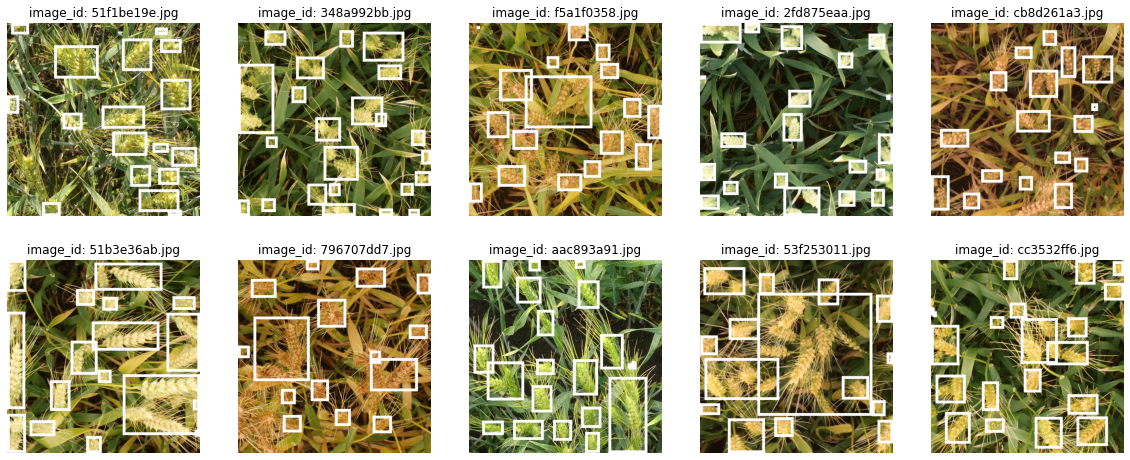

In [50]:
from PIL import Image, ImageDraw

row=2
col=5
f, ax = plt.subplots(row,col, figsize=(20, 8))
for i, image_id in enumerate(test_ids):
    
    test_bboxes_processed = [get_params_from_bbox(bb.bbox, scaling_factor=SC_FACTOR) for bb in bboxes[i]]
#     print(image_id," ", test_bboxes_processed," \n")
    image_path = os.path.join(TEST_PATH, f'{image_id}')
    image = Image.open(image_path)    
    draw = ImageDraw.Draw(image)
    for test_bbox in test_bboxes_processed:    
        draw.rectangle([test_bbox[0], test_bbox[1], 
                        test_bbox[0] + test_bbox[2], test_bbox[1] + test_bbox[3]], 
                        width=15)
    ax[i//col, i%col].imshow(image) 
    ax[i//col, i%col].axis('off')
    ax[i//col, i%col].set_title(f"image_id: {image_id}")

plt.show()

**submission**

In [ ]:
# Here we format the bboxes into the required format
output = dict()

for i, image_id in enumerate(test_ids):
# for i in range(masked_preds.shape[0]):
    # bbox -> (x_min, y_min, w, h)
    bboxes_processed = [get_params_from_bbox(bb.bbox, scaling_factor=SC_FACTOR) for bb in bboxes[i]]
#     print(i, bboxes_processed)
    formated_boxes = ['1.0 ' + ' '.join(map(str, bb_m)) for bb_m in bboxes_processed]
    
    output[image_id] = " ".join(formated_boxes)
#     print(output)

In [ ]:
sample_sub['image_id'] = output.keys()
sample_sub["PredictionString"] = output.values()
# sample_sub.to_csv('submission.csv', index=False)
display(sample_sub)